# Radial Basis Function

In [1]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load data
X_train_input = np.load("Data/X_train.npy")  # shape (700, 6)
Y_train_input = np.load("Data/Y_train.npy")  # shape (700,)

# Random train/test split (200 for test, 500 for training and cross-validation)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_input, Y_train_input, test_size=200, random_state=100, shuffle=True
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# RBF transformation function
def rbf_transform(X, centers, sigma):
    diff = X[:, np.newaxis, :] - centers[np.newaxis, :, :]
    return np.exp(-np.sum(diff**2, axis=2) / (2 * sigma**2))

# Hyperparameter grids - Initial
#sigma_list = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0]
#n_centers_list = [20, 30, 40, 50, 100, 125, 150, 200]
#alpha_list = [0.001, 0.005, 0.01, 0.1, 1.0, 10.0]

# Hyperparameter grids - Specialized
sigma_list = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
n_centers_list = [150, 175, 200, 225, 250]
alpha_list = [0.0001, 0.0005, 0.00075, 0.001, 0.005]


# K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=100)

best_r2 = -np.inf
best_params = None
results = []

In [ ]:
for sigma, n_centers, alpha in product(sigma_list, n_centers_list, alpha_list):
    
    r2_scores = []
    
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        Y_tr, Y_val = Y_train[train_idx], Y_train[val_idx]
        
        # KMeans centers on training fold
        kmeans = KMeans(n_clusters=n_centers, random_state=100).fit(X_tr)
        centers = kmeans.cluster_centers_
        
        # Transform both training and validation data
        X_tr_rbf = rbf_transform(X_tr, centers, sigma)
        X_val_rbf = rbf_transform(X_val, centers, sigma)
        
        # Train Ridge regression
        model = Ridge(alpha=alpha)
        model.fit(X_tr_rbf, Y_tr)
        
        # Predict on validation fold
        Y_val_pred = model.predict(X_val_rbf)
        r2_scores.append(r2_score(Y_val, Y_val_pred))
    
    mean_r2 = np.mean(r2_scores)
    results.append({'sigma': sigma, 'n_centers': n_centers, 'alpha': alpha, 'mean_r2': mean_r2})
    
    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_params = {'sigma': sigma, 'n_centers': n_centers, 'alpha': alpha}

print("Best Cross Validation R2:", best_r2)
print("Best Hyperparameters:", best_params)

Best Cross Validation R2: 0.9829335637292148
Best Hyperparameters: {'sigma': 1.9, 'n_centers': 250, 'alpha': 0.0001}


In [ ]:
# Refit model on all 500 training samples using best hyperparameters
sigma_best = best_params['sigma']
n_centers_best = best_params['n_centers']
alpha_best = best_params['alpha']

# KMeans centers on full training fold
kmeans = KMeans(n_clusters=n_centers_best, random_state=100).fit(X_train_scaled)
centers_best = kmeans.cluster_centers_

# Transform training and test data
X_train_rbf = rbf_transform(X_train_scaled, centers_best, sigma_best)
X_test_rbf = rbf_transform(X_test_scaled, centers_best, sigma_best)

# Train final model
final_model = Ridge(alpha=alpha_best)
final_model.fit(X_train_rbf, Y_train)

# Predict on held-out 200 samples
Y_test_pred = final_model.predict(X_test_rbf)
test_r2 = r2_score(Y_test, Y_test_pred)
print("R2 on held-out 200 test samples:", test_r2)

R2 on held-out 200 test samples: 0.9824190032200999


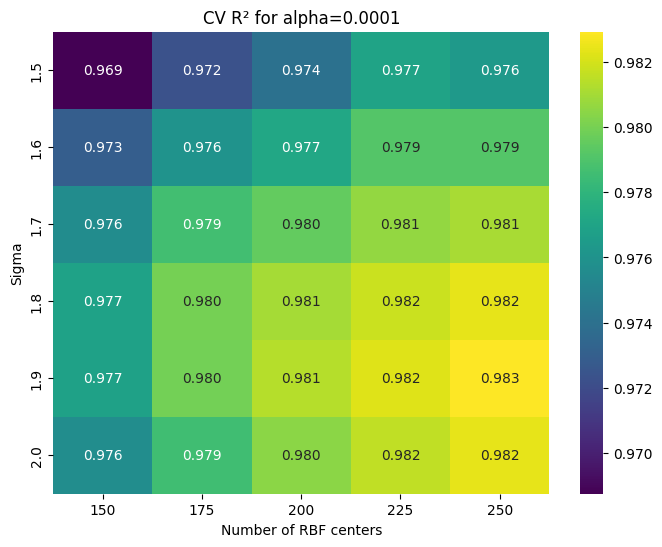

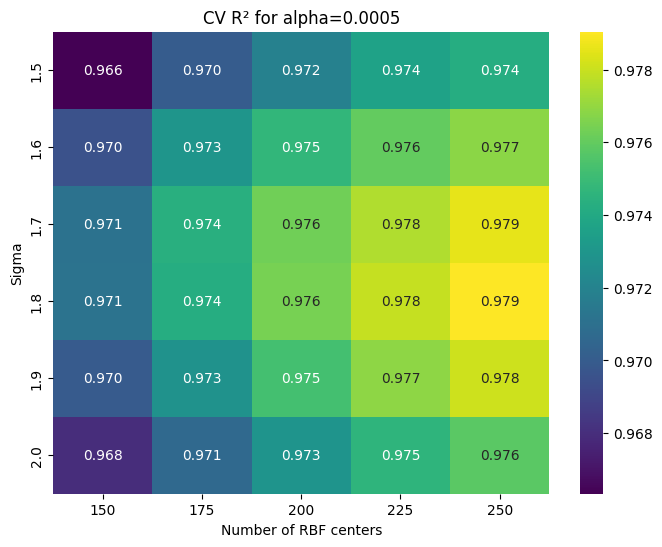

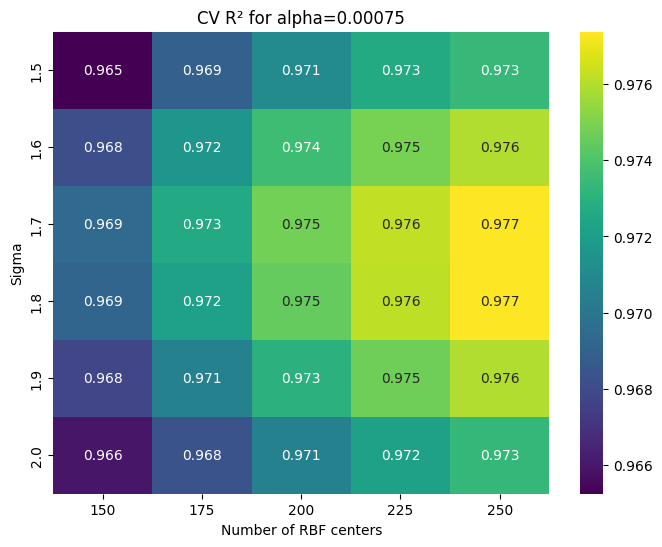

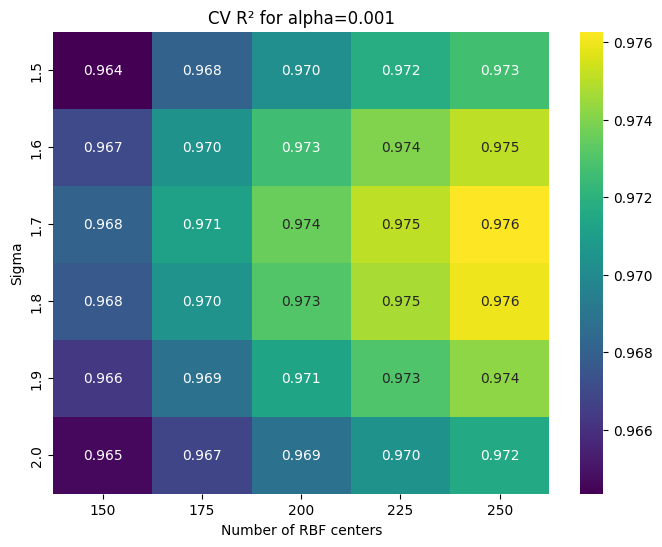

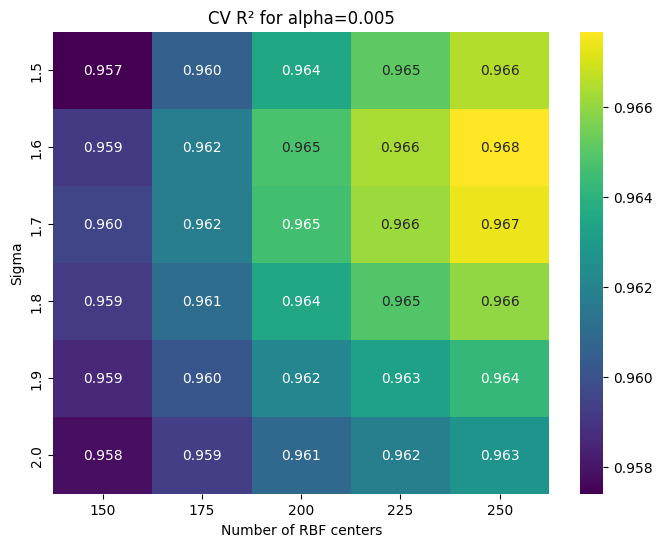

In [6]:
# Convert results to arrays for plotting
sigmas = sigma_list
n_centers_vals = n_centers_list

# Plot heatmaps for each alpha
for alpha in alpha_list:
    heatmap_data = np.zeros((len(sigmas), len(n_centers_vals)))
    
    for i, sigma in enumerate(sigmas):
        for j, n_centers in enumerate(n_centers_vals):
            # find corresponding mean_r2
            for r in results:
                if r['sigma']==sigma and r['n_centers']==n_centers and r['alpha']==alpha:
                    heatmap_data[i, j] = r['mean_r2']
    
    plt.figure(figsize=(8,6))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", xticklabels=n_centers_vals, yticklabels=sigmas, cmap="viridis")
    plt.title(f"CV R² for alpha={alpha}")
    plt.xlabel("Number of RBF centers")
    plt.ylabel("Sigma")
    plt.show()

Add Average and Median to Train Data

In [7]:
# Original shape: (n_samples, 6)
X_train_new = np.hstack([
    X_train,
    np.mean(X_train, axis=1, keepdims=True),
    np.median(X_train, axis=1, keepdims=True)
])

X_test_new = np.hstack([
    X_test,
    np.mean(X_test, axis=1, keepdims=True),
    np.median(X_test, axis=1, keepdims=True)
])

# Scale new features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_new)
X_test_scaled = scaler.transform(X_test_new)

In [ ]:
# RBF transformation function
def rbf_transform(X, centers, sigma):
    diff = X[:, np.newaxis, :] - centers[np.newaxis, :, :]
    return np.exp(-np.sum(diff**2, axis=2) / (2 * sigma**2))

# Hyperparameter grids - Initial
#sigma_list = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0]
#n_centers_list = [20, 30, 40, 50, 100, 125, 150, 200]
#alpha_list = [0.001, 0.005, 0.01, 0.1, 1.0, 10.0]

# Hyperparameter grids - Specialized
sigma_list = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
n_centers_list = [150, 175, 200, 225, 250]
alpha_list = [0.0001, 0.0005, 0.00075, 0.001, 0.005]


# K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=100)

best_r2 = -np.inf
best_params = None

# Example: results = [{'sigma': s, 'n_centers': n, 'alpha': a, 'mean_r2': r2}, ...]
results = []

In [ ]:
for sigma, n_centers, alpha in product(sigma_list, n_centers_list, alpha_list):
    
    r2_scores = []
    
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        Y_tr, Y_val = Y_train[train_idx], Y_train[val_idx]
        
        # KMeans centers on training fold
        kmeans = KMeans(n_clusters=n_centers, random_state=100).fit(X_tr)
        centers = kmeans.cluster_centers_
        
        # Transform both training and validation data
        X_tr_rbf = rbf_transform(X_tr, centers, sigma)
        X_val_rbf = rbf_transform(X_val, centers, sigma)
        
        # Train Ridge regression
        model = Ridge(alpha=alpha)
        model.fit(X_tr_rbf, Y_tr)
        
        # Predict on validation fold
        Y_val_pred = model.predict(X_val_rbf)
        r2_scores.append(r2_score(Y_val, Y_val_pred))
    
    mean_r2 = np.mean(r2_scores)
    results.append({'sigma': sigma, 'n_centers': n_centers, 'alpha': alpha, 'mean_r2': mean_r2})
    
    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_params = {'sigma': sigma, 'n_centers': n_centers, 'alpha': alpha}

print("Best Cross Validation R2:", best_r2)
print("Best Hyperparameters:", best_params)

Best Cross Validation R2: 0.9745404421361326
Best Hyperparameters: {'sigma': 1.9, 'n_centers': 250, 'alpha': 0.0001}


In [ ]:
# Refit model on all 500 training samples using best hyperparameters
sigma_best = best_params['sigma']
n_centers_best = best_params['n_centers']
alpha_best = best_params['alpha']

# KMeans centers on full training fold
kmeans = KMeans(n_clusters=n_centers_best, random_state=100).fit(X_train_scaled)
centers_best = kmeans.cluster_centers_

# Transform training and test data
X_train_rbf = rbf_transform(X_train_scaled, centers_best, sigma_best)
X_test_rbf = rbf_transform(X_test_scaled, centers_best, sigma_best)

# Train final model
final_model = Ridge(alpha=alpha_best)
final_model.fit(X_train_rbf, Y_train)

# Predict on held-out 200 samples
Y_test_pred = final_model.predict(X_test_rbf)
test_r2 = r2_score(Y_test, Y_test_pred)
print("R2 on held-out 200 test samples:", test_r2)

R2 on held-out 200 test samples: 0.9698986152545038
